In [1]:
# Numerical Libraries
import numpy as np
import pandas as pd
import scipy
# Standard
import datetime, time, math, random
# Data Import Libraries
import yfinance as yf
import pandas_datareader as pdr
import pandas_datareader.data as web
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')
# Utility Programs
from pathlib import Path
import os, pickle
# Hidden Markov Models and PGMPY
from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.readwrite import BIFReader
# Plots
import seaborn as sns
import networkx as nx
from pylab import plt, mpl
from pandas.plotting import scatter_matrix
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

In [2]:
with open('C:/MScFE/Capstone/Models/BayesianK2.pkl', 'rb') as file:
    Bayesian_K2F_Model = pickle.load(file)

In [7]:
# Enter the Date in 'YYYY-MM-DD' format, on which we want to generate the Signal. 
# Condition 1. If the current date is passed (not more than 3 days), the Date when Signal should be last generated, use that date for Signal
# Act: In this condition, if the Forecast Signal is 1 Rebalance to TAA, else stay with SAA.
# Condition 2. If current data is less than Date when Signal should be generated. We can use the Signal date
# Run this system again close to the Date of Signal and Act as per above

In [5]:
Tickers = ['^BSESN','000001.SS','ISF.L', 'ESS', '^GSPC', 'GOLD.AX']
Macro_S = ['DFF', 'DFII10', 'T5YIE', 'GVZCLS']
GeoP_S = ['CIVPART', 'PAYEMS', 'UNRATE','USACPICORMINMEI']
# High Yield Corporate Bond Data
Series = "BAMLHYH0A0HYM2TRIV"

In [4]:
ColumnsT = ['WTISPLC', 'US_Gold_EXP', 'BofA', '^BSESN', 'China_EQ', 'ISF.L', 'ESS',
            '^GSPC', 'GOLD.AX', 'DFF', 'DFII10', 'T5YIE', 'GOLD_VIX', 'CIVPART','PAYEMS', 'UNRATE', 'US_CPI']

In [2]:
# Enter End Date for which the Signal needs to be generated
End_Date = "2023-02-01"

In [3]:
S_Date = ""
M = int(End_Date[5] + End_Date[6])
if M ==1:
    S_Date = str(int(End_Date[:4])-1)+"-11-01"
if M ==2:
    S_Date = str(int(End_Date[:4])-1)+"-12-01"
else:
    S_Date = End_Date[:5]+str(M-2)+"-01"

In [4]:
S_Date

'2022-12-01'

In [19]:
# Function to get simple stock prices from Yahoo. Input stock code as in Yahoo URL and Start/End Date YYYY-MM-DD
def GetQuotes(S, Start, End):
    '''
    S: List/Iterable of Stock Quotes as in Yahoo URL for Download e.g MSFT for Microsoft
    Start: Date in YYYY-MM-DD
    End: Date in YYYY-MM-DD
    '''
    Prices = []
    t1 = int(pd.to_datetime(Start).timestamp())
    t2 = int(pd.to_datetime(End).timestamp())
    for i in S:
        URL = 'https://query1.finance.yahoo.com/v7/finance/download/'+i + '?period1=' + str(int(t1)) + '&period2='+ str(int(t2)) + '&interval=1d&events=history&includeAdjustedClose=true'
        Stock_DF = pd.read_csv(URL, header = 0, encoding = 'utf-8')
        Date_DT = pd.to_datetime(Stock_DF['Date'])
        Stock_DF.insert(1,'DateTime', Date_DT, allow_duplicates = False)
        Stock_DF = Stock_DF.drop(['Date'], axis=1).set_index('DateTime')
        Prices.append(Stock_DF)
    return Prices

In [20]:
def GetAdjCloseQuotes(S, Start, End):
    '''
    S: List/Iterable of Stock Quotes as in Yahoo URL for Download e.g MSFT for Microsoft
    Start: Date in YYYY-MM-DD
    End: Date in YYYY-MM-DD
    '''
    P = GetQuotes(S, Start, End)
    P_DF = []
    for i in range(len(P)):
        P_DF.append(pd.DataFrame(P[i]['Adj Close'].values, index = P[i].index, columns = [S[i]]))
    return P_DF[0].join(P_DF[1:], how = 'inner')
def ReturnsPerClose(DF):
    DF_Arr = DF.values
    DF_Ret = np.log(DF_Arr[1:]) - np.log(DF_Arr[:-1])
    return pd.DataFrame(DF_Ret, index = DF.index[1:], columns = DF.columns)
def ReturnsPerDay(DF):
    DF_Arr = DF.values
    Days_Diff = DF.index[1:] - DF.index[:-1]
    Days = np.array([i.days for i in Days_Diff])
    Log_Returns = (np.log(DF_Arr[1:]) - np.log(DF_Arr[:-1]))/Days.reshape(-1,1)
    Log_Returns_DF = pd.DataFrame(Log_Returns, index = DF.index[1:], columns = DF.columns)
    Log_Returns_DF.insert(0,'Days', Days, allow_duplicates = False)
    return Log_Returns_DF
# Using code from FRED API: Get US Economic Data using Python
def get_fred_data(param_list, start_date, end_date):
    df = pdr.DataReader(param_list, "fred", start_date, end_date)
    return df.reset_index()

In [ ]:
# Strategic Asset Price Series
Imp_Prices = GetAdjCloseQuotes(Tickers, S_Date, End_Date)

In [ ]:
# Use YFinance over Proxy. If there is no Proxy then remove 'proxy' parameter
Data_ = yf.download(Tickers, start=S_Date, end=End_Date,
                   group_by="ticker", proxy = 'http://127.0.0.1:10809')
Combine_DF = pd.DataFrame(Data_[(Tickers[0],'Adj Close')].values, index = Data_.index, columns = [Tickers[0]])
for i in Tickers[1:]:
    Combine_DF.insert(len(Combine_DF.columns), i, Data_[(i,'Adj Close')],allow_duplicates = False)

In [ ]:
Combine_DF = GetAdjCloseQuotes(Tickers, S_Date, End_Date)

In [ ]:
Crude_P = get_fred_data(param_list='WTISPLC', start_date=S_Date, end_date=End_Date).set_index('DATE')
Gold_P = get_fred_data(param_list='IQ12260', start_date=S_Date, end_date=End_Date).set_index('DATE')
# Get Data for Macroeconomic Index Series. We drop NaN. Since missing data can't be simply imputed
# https://fred.stlouisfed.org/series/GVZCLS Gold ETF Volatility Index
# Macro_S = ['DFF', 'DFII10', 'T5YIE', 'GVZCLS']
Macro_IDX = get_fred_data(param_list=Macro_S, start_date=S_Date, end_date=End_Date).set_index('DATE').dropna()
# Microeconomic Price Series
# Extract API Key: Put Your Key in Angle Brackets <>
fred_api_key = "<75614e192d7c2860f42a90dd9447019a>"
# Let's see what the Bond Index was since 2000. # Series = "BAMLHYH0A0HYM2TRIV"
# Get Data for Bond Total Index Series
Bond_IDX = get_fred_data(param_list=[Series], start_date=S_Date, end_date=End_Date).set_index('DATE')
# Join the Bond Index Data with Other Assets (Goldman Sachs GOLD ETF, FTSE, Essex REIT Index and S&P 500)
Bond_IDX = Bond_IDX.join(Combine_DF, how = 'inner').rename(columns = {'000001.SS':'China_EQ'}).dropna()
# Get Data for Geopolitical Indices/Series
# GeoP_S = ['CIVPART', 'PAYEMS', 'UNRATE','USACPICORMINMEI']
GeoP_IDX = get_fred_data(param_list=GeoP_S, start_date=S_Date, end_date=End_Date).set_index('DATE')
Gold_ETF_VIX = Macro_IDX.iloc[:,3].pct_change()
# Append the column into the DataFrame just after the 'T5YIE' column
Macro_IDX.insert(3,'GOLD_VIX', Gold_ETF_VIX, allow_duplicates = False)
Macro_IDX = Macro_IDX.drop(['GVZCLS'], axis=1)
# Microeconomic Series has Price Values. We take Logarithmic Returns per Close to scale 'Extreme Values'. No NaN
Bond_IDX_R_DF = ReturnsPerClose(Bond_IDX)
# For GeoPolitical Data, we are interested in the change and not in the absolute values. 
# Hence a change in Labor Force Participation Rate, Employed Worker, Unemployment rate and CPI is required.
GeoP_IDX = GeoP_IDX.pct_change().dropna()
Macro_IDX = Macro_IDX.dropna()

In [ ]:
# Microeconomic Data - Daily to Monthly(Simulated by Averaging for Month)
C_IDX = []
# Take each date 1st of Month, from Crude Oil Price DF (Monthly). Average Daily Prices for last Month for Indices
for i in Gold_P.index:
    if i.month == 1:
        C_IDX.append(Bond_IDX_R_DF.index[[j.month ==12 and j.year == i.year -1 for j in Bond_IDX_R_DF.index]])
    else :
        C_IDX.append(Bond_IDX_R_DF.index[[j.month ==i.month -1 and j.year == i.year for j in Bond_IDX_R_DF.index]])
# Macroeconomic Data - Daily to Monthly(Simulated by Averaging for Month)
M_IDX = []
# Take each date 1st of Month, from Crude Oil Price DF (Monthly). Average Daily Prices for last Month for Indices
for i in Gold_P.index:
    if i.month == 1:
        M_IDX.append(Macro_IDX.index[[j.month ==12 and j.year == i.year -1 for j in Macro_IDX.index]])
    else :
        M_IDX.append(Macro_IDX.index[[j.month ==i.month -1 and j.year == i.year for j in Macro_IDX.index]])
D_R_IDX = {i:[] for i in Bond_IDX_R_DF.columns}
R_Keys = D_R_IDX.keys()
for i in C_IDX:
    IDX_Mean = Bond_IDX_R_DF.loc[i].mean()
    for j in R_Keys:
        D_R_IDX[j].append(IDX_Mean[j])
IDX_Rm_DF = pd.DataFrame(D_R_IDX, index = Gold_P.index)
D_Macro_IDX = {i:[] for i in Macro_IDX.columns}
M_Keys = D_Macro_IDX.keys()
for i in M_IDX:
    IDX_Mean_DF = Macro_IDX.loc[i]
    IDX_Mean_DF.replace([np.inf, -np.inf], 0, inplace=True)
    IDX_Mean = IDX_Mean_DF.mean()
    for j in M_Keys:
        D_Macro_IDX[j].append(IDX_Mean[j])
Macro_m_IDX = pd.DataFrame(D_Macro_IDX, index = Crude_P.index)
CombineM_DF = IDX_Rm_DF.join([Macro_m_IDX, GeoP_IDX], how = 'inner').dropna()

In [ ]:
Crude_R_DF = ReturnsPerClose(Crude_P)
Gold_R_DF = ReturnsPerClose(Gold_P)
Combine_R_DF = Crude_R_DF.join([Gold_R_DF,CombineM_DF], how = 'inner').rename(columns = {'BAMLHYH0A0HYM2TRIV':'BofA',
                                                                                        'USACPICORMINMEI':'US_CPI',
                                                                                        'IQ12260':'US_Gold_EXP'})

In [ ]:
Discrete_DF = Combine_R_DF.diff()[1:]
for i in Discrete_DF.columns:
    Discrete_DF[i] = Discrete_DF[i].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# Choice K2F Model
# Predict using Bayesian_K2_Model, Pass DataFrame with only columns containing 'Observed' variables (States). 
# .predict method returns Value of the 'Inferred' variable, with the Highest Probability.
K2F_Model_V = Bayesian_K2F_Model.predict(Discrete_DF.iloc[-1:,:])

In [34]:
Test = pd.DataFrame(np.array([0,1,1,0,0,1,0,1,0,0,1,0,1,1,0,1,0]).reshape(1,-1), columns = ColumnsT)

In [35]:
Bayesian_K2F_Model.predict(Test)

  0%|          | 0/1 [00:00<?, ?it/s]

,Forecast
0,1.0


In [ ]:
K2F_Model_V

#### Appendix

In [33]:
Bayesian_K2F_Model.edges()

OutEdgeView([('WTISPLC', 'UNRATE'), ('BofA', 'DFII10'), ('BofA', '^GSPC'), ('BofA', 'PAYEMS'), ('BofA', '^BSESN'), ('BofA', 'US_CPI'), ('^BSESN', 'GOLD.AX'), ('China_EQ', '^GSPC'), ('China_EQ', 'PAYEMS'), ('ISF.L', 'BofA'), ('ISF.L', '^GSPC'), ('ISF.L', 'China_EQ'), ('^GSPC', '^BSESN'), ('^GSPC', 'GOLD_VIX'), ('^GSPC', 'ESS'), ('^GSPC', 'US_CPI'), ('^GSPC', 'PAYEMS'), ('GOLD.AX', 'US_Gold_EXP'), ('GOLD.AX', 'Forecast'), ('DFF', 'US_Gold_EXP'), ('DFF', 'UNRATE'), ('DFII10', 'GOLD.AX'), ('DFII10', 'PAYEMS'), ('T5YIE', 'PAYEMS'), ('T5YIE', 'WTISPLC'), ('T5YIE', 'GOLD.AX'), ('GOLD_VIX', 'GOLD.AX'), ('GOLD_VIX', 'DFII10'), ('GOLD_VIX', '^BSESN'), ('GOLD_VIX', 'PAYEMS'), ('CIVPART', 'GOLD.AX'), ('CIVPART', 'UNRATE'), ('CIVPART', 'ISF.L'), ('CIVPART', 'PAYEMS'), ('PAYEMS', 'GOLD.AX'), ('UNRATE', '^GSPC'), ('UNRATE', 'PAYEMS'), ('US_CPI', 'ESS')])

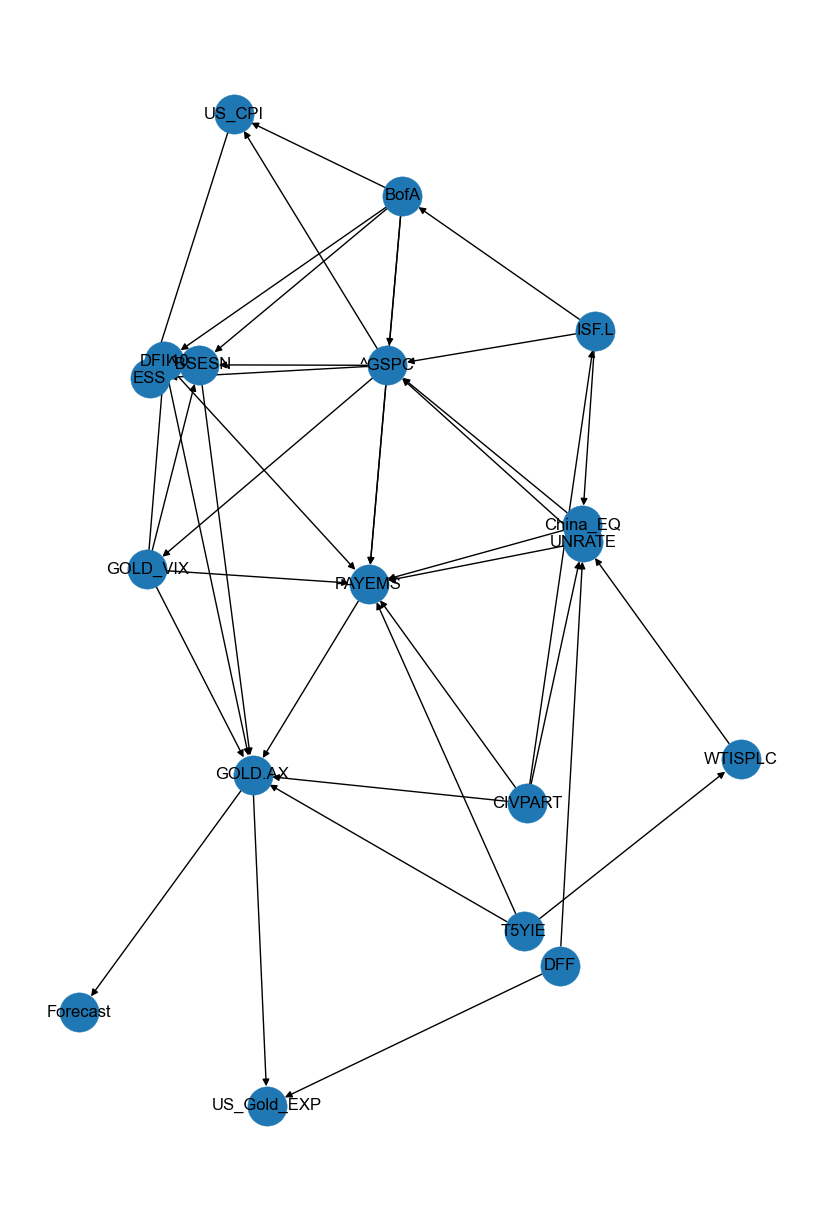

In [45]:
G = nx.DiGraph(Bayesian_K2F_Model.edges())
nx.draw(G, pos = nx.kamada_kawai_layout(G), node_size = 800, with_labels=True)
plt.rcParams['figure.figsize'] = [8,12]
plt.show()